In [126]:
# establishing environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# ACQUIRE
I'll begin by acquiring the data from a local CSV file.

In [127]:
df = pd.read_csv('aac_shelter_outcomes.csv')

df.head(40)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male
6,1 year,A693700,Other,Squirrel Mix,Tan,2013-12-13T00:00:00,2014-12-13T12:20:00,2014-12-13T12:20:00,NaN,Suffering,Euthanasia,Unknown
7,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,Transfer,Spayed Female
8,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,Adoption,Intact Female
9,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,Adoption,Spayed Female


# PREPARE
I'm now going to prepare the data for exploration.
***

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


After reviewing the data and my goals for this project, I'll need to make the following changes:
- Drop the following columns
    - animal_id
        - Unique id's won't be useful in predicting outcomes
    - breed
        - Highly variable, categorical column. 
        - At a later time I'd like to bin these values and explore them for statistical signifigance
    - color
        - Highly variable, categorical column. 
        - At a later time I'd like to bin these values and explore them for statistical signifigance
    - date_of_birth
        - Since I have the age of each animal at the time of outcome, I won't need to calculate their age using this variable
    - datetime, monthyear
        - Duplicate columns that presumably reflect when a record was entered and are thus not useful for predicting outcomes
    - outcome_subtype
        - Gives details about outcome (example: why was an animal euthanised?)
        - May prove useful but appears to only be known when the outcome is known (example: (outcome_subtype partner) (outcome_type: transfer) could only be known when an animal is set for transfer to a partner)
        - The value of this project is to create a model that will predict if an animal will be adopted, so outcome_subtype probably wouldn't be set until outcome is set, so I'm going to drop it for now
    - Any columns that are split into categorical columns and no longer needed
- Rename columns to better reflect the data they represent
- Convert age_upon_outcome to discrete value representing weeks
- Convert animal type to categorical columns
    - is_cat
    - is_dog
- Transform outcome_type to binary categorical column 'adopted' ( 1 = yes, 2 = no)
- Split sex_upon_outcome into categorical columns for neutered/spaded and sex
    - is_neutered_or_spaded
    - is_male
    - is_female
    - sex_unknown
- Drop null values
    - Very few nulls so dropping won't have a meaningful impact

### Dropping columns and nulls

In [129]:
df = df[['age_upon_outcome', 'animal_type', 'sex_upon_outcome', 'color', 'outcome_type']]

df.dropna(inplace = True)

### Binning age data (may remove)

In [130]:
#df.age_upon_outcome.value_counts(dropna=False)

df['age_under_1'] = np.where(
    (df.age_upon_outcome.str.contains('week')) | 
    (df.age_upon_outcome.str.contains('month')) |
    (df.age_upon_outcome.str.contains('days')), 1, 0)

df['age_between_1_and_2'] = np.where((df.age_upon_outcome.str.contains('1 year')), 1, 0)

df['age_2_or_more'] = np.where((df.age_upon_outcome.str.contains('years')), 1, 0)

### animal type

In [131]:
df.animal_type.value_counts()

Dog          44234
Cat          29418
Other         4243
Bird           333
Livestock        9
Name: animal_type, dtype: int64

In [132]:
# change livestock to other
df['animal_type'] = np.where((df.animal_type == 'Livestock'), 'Other', df.animal_type)

# dummies
df.animal_type = df.animal_type.str.lower()

a_type = pd.get_dummies(df.animal_type, prefix = 'is')

df = pd.concat([df, a_type], axis = 1)

### sex upon outcome

In [133]:
df.sex_upon_outcome.value_counts()

Neutered Male    27782
Spayed Female    25203
Intact Male       9544
Intact Female     9139
Unknown           6569
Name: sex_upon_outcome, dtype: int64

In [134]:
df['is_male'] = np.where((df.sex_upon_outcome.str.contains('Male')), 1, 0)
df['is_female'] = np.where((df.sex_upon_outcome.str.contains('Female')), 1, 0)
df['sex_unknown'] = np.where((df.sex_upon_outcome.str.contains('Unknown')), 1, 0)

In [135]:
df['sex'] = np.where((df.sex_upon_outcome.str.contains('Male')), 'Male', 0)
df['sex'] = np.where((df.sex_upon_outcome.str.contains('Female')), 'Female', df.sex)
df['sex'] = np.where((df.sex_upon_outcome.str.contains('Unknown')), 'Unknown', df.sex)

In [136]:
df['is_neutered_or_spayed'] = np.where(
    (df.sex_upon_outcome.str.contains('Neutered')) |
    (df.sex_upon_outcome.str.contains('Spayed')), 1, 0)

### outcome_type (target variable)

In [137]:
df.outcome_type.value_counts()

Adoption           33112
Transfer           23497
Return to Owner    14353
Euthanasia          6076
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [138]:
df['is_adopted'] = np.where((df.outcome_type.str.contains('Adopt')), 1, 0)

### Alternate age column

In [139]:
age_split = df.age_upon_outcome.str.split(expand=True)

age_split.columns = (['num', 'period'])

age_split.num = pd.to_numeric(age_split.num)

age_split['age_in_weeks'] = np.where((age_split.period.str.contains('day')), 1, 0)
age_split['age_in_weeks'] = np.where((age_split.period.str.contains('week')), age_split.num, age_split.age_in_weeks)
age_split['age_in_weeks'] = np.where((age_split.period.str.contains('month')), age_split.num * 4, age_split.age_in_weeks)
age_split['age_in_weeks'] = np.where((age_split.period.str.contains('year')), age_split.num * 52, age_split.age_in_weeks)

df = pd.concat([df, age_split['age_in_weeks']], axis = 1)

In [140]:
df.columns

Index(['age_upon_outcome', 'animal_type', 'sex_upon_outcome', 'color',
       'outcome_type', 'is_bird', 'is_cat', 'is_dog', 'is_other', 'is_male',
       'is_female', 'sex_unknown', 'sex', 'is_neutered_or_spayed',
       'is_adopted', 'age_in_weeks'],
      dtype='object')

### Copy original df, split copy, drop old columns

In [141]:
df = df[['animal_type', 'is_bird', 'is_cat', 'is_dog', 'is_other', 'sex', 'is_male',
       'is_female', 'sex_unknown', 'is_neutered_or_spayed', 'age_in_weeks', 'is_adopted']]

In [142]:
def split_data(df):
    """
    Accepts DF. Returns data split into 3 dataframes: train, validate, and test.
    """
    # splitting data
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # return split data frames
    return train, validate, test


In [143]:
train, validate, test = split_data(df)

# Explore
I'm now going to explore the data to identify drivers of adoption.
***

## animal type

In [156]:
observed_atype = pd.crosstab(train.animal_type, train.is_adopted)

observed_atype 

is_adopted,0,1
animal_type,,
bird,119,52
cat,9331,7114
dog,13467,11381
other,2235,113


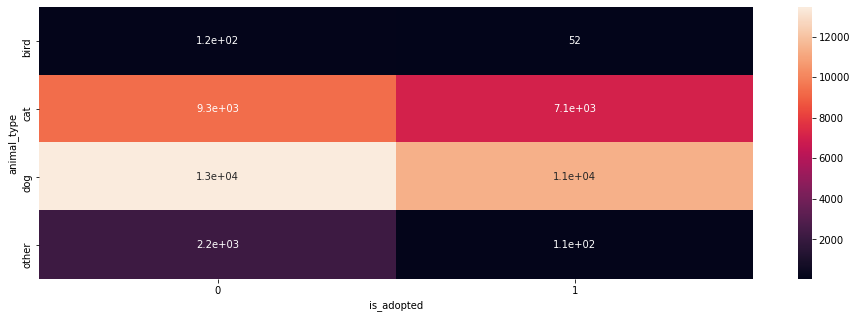

In [158]:
plt.figure(figsize = (16,5))
sns.heatmap(observed_atype, annot=True)

In [145]:
chi2, p, degf, expected = stats.chi2_contingency(observed_atype)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 1488.7177
p     = 0.0000


## sex

In [146]:
observed_sex = pd.crosstab(train.sex, train.is_adopted)

observed_sex

is_adopted,0,1
sex,,
Female,9889,9329
Male,11670,9301
Unknown,3593,30


In [147]:
chi2, p, degf, expected = stats.chi2_contingency(observed_sex)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 2889.3938
p     = 0.0000


## neutered or spayed

In [230]:
observed_nors = pd.crosstab(train.is_neutered_or_spayed, train.is_adopted)

observed_nors

is_adopted,0,1
is_neutered_or_spayed,,
0,13276,842
1,11876,17818


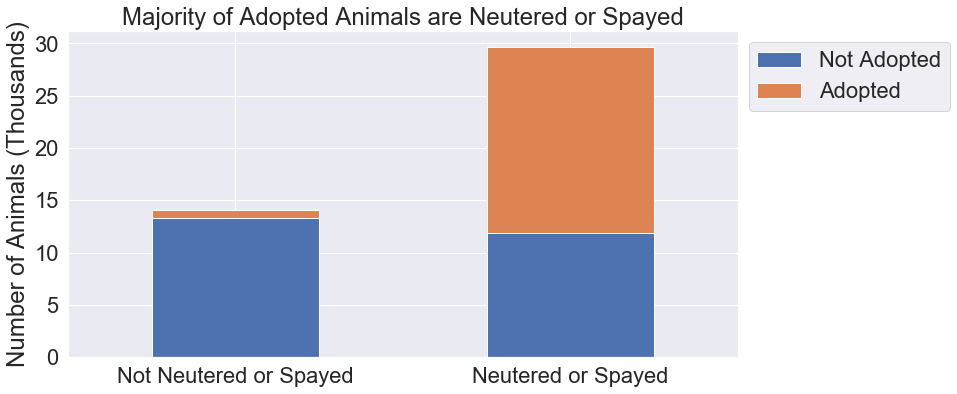

In [231]:
observed_nors.index = ['Not Neutered or Spayed', 'Neutered or Spayed']
observed_nors.columns = ['Not Adopted', 'Adopted']

nors_plot = observed_nors / 1000

nors_plot.plot.bar(stacked=True, rot=0)

plt.ylabel('Number of Animals (Thousands)')
plt.title('Majority of Adopted Animals are Neutered or Spayed')
plt.legend(bbox_to_anchor=(1,1))

In [192]:
chi2, p, degf, expected = stats.chi2_contingency(observed_nors)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 11426.6656
p     = 0.0000


## age in weeks

(array([1.2771e+04, 3.3260e+03, 1.0670e+03, 6.0500e+02, 2.9900e+02,
        3.4200e+02, 1.5100e+02, 6.8000e+01, 2.6000e+01, 5.0000e+00]),
 array([  0. ,  93.6, 187.2, 280.8, 374.4, 468. , 561.6, 655.2, 748.8,
        842.4, 936. ]),
 <a list of 10 Patch objects>)

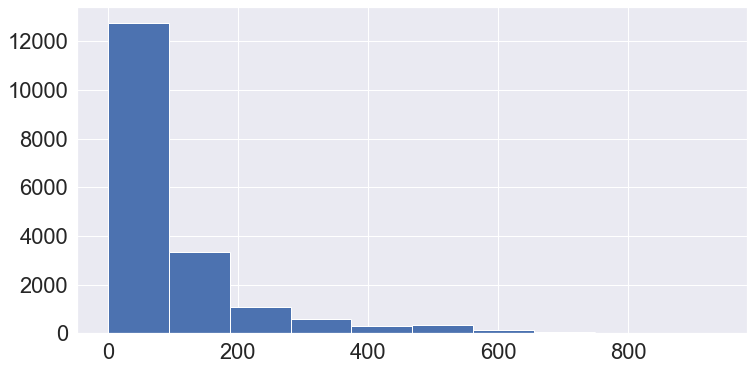

In [185]:
# setting figure and text size
adopted = train[train.is_adopted == 1]
adopted
plt.hist(adopted.age_in_weeks)

In [168]:
# x1 = df of animals who are younger than average
# x2 = df of animals who are average age or older
x1 = train[train.is_adopted == 1].age_in_weeks
x2 = train[train.is_adopted == 0].age_in_weeks

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p/2}')
print (f't = ',t)

alpha = .05

p = 1.7634740875777462e-182
t =  -28.919521980419926


In [170]:
print('reject null hypo')
print('the average age of adopted animals is significantly less than those who are note adopted')

reject null hypo
the average age of adopted animals is significantly less than those who are note adopted


# Model
I'll now create several models that will predict whether an animal was adopted based on it's various features.
***

## Baseline

In [64]:
train.is_adopted.value_counts()

0    25152
1    18660
Name: is_adopted, dtype: int64

In [65]:
train['baseline_pred'] = 0

In [66]:
# printing performance metrics
print(classification_report(train.is_adopted, train.baseline_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     25152
           1       0.00      0.00      0.00     18660

    accuracy                           0.57     43812
   macro avg       0.29      0.50      0.36     43812
weighted avg       0.33      0.57      0.42     43812



# TRAIN

## M1

In [67]:
# setting target variable
y_train = train['is_adopted']

# setting feature for model
X_train_m1 = train[['is_bird', 'age_in_weeks',
       'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 'sex_unknown',
       'is_neutered_or_spayed']]

# creating logistic regression object
lr_m1 = LogisticRegression(random_state=123)

# fitting model to data
lr_m1.fit(X_train_m1, y_train)

# creating column with model predictions
train['m1_prediction'] = lr_m1.predict(X_train_m1)

# printing performance metrics
print(classification_report(train.is_adopted, train.m1_prediction))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     25152
           1       0.66      0.84      0.74     18660

    accuracy                           0.75     43812
   macro avg       0.76      0.76      0.75     43812
weighted avg       0.77      0.75      0.75     43812



# VALIDATE

In [69]:
# setting target variable
y_val = validate['is_adopted']

# setting feature for model
X_val_m1 = validate[['is_bird', 'age_in_weeks',
       'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 'sex_unknown',
       'is_neutered_or_spayed']]

# creating column with model predictions
validate['m1_prediction'] = lr_m1.predict(X_val_m1)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m1_prediction))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     10815
           1       0.66      0.84      0.74      7962

    accuracy                           0.75     18777
   macro avg       0.76      0.76      0.75     18777
weighted avg       0.77      0.75      0.75     18777



# TEST

In [70]:
# setting target variable
y_test = test['is_adopted']

# setting feature for model
X_test_m1 = test[['is_bird', 'age_in_weeks',
       'is_cat', 'is_dog', 'is_other', 'is_male', 'is_female', 'sex_unknown',
       'is_neutered_or_spayed']]

# creating column with model predictions
test['m1_prediction'] = lr_m1.predict(X_test_m1)

# printing performance metrics
print(classification_report(test.is_adopted, test.m1_prediction))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      9008
           1       0.66      0.84      0.74      6640

    accuracy                           0.75     15648
   macro avg       0.76      0.76      0.75     15648
weighted avg       0.77      0.75      0.75     15648



In [173]:
train

,animal_type,is_bird,is_cat,is_dog,is_other,sex,is_male,is_female,sex_unknown,is_neutered_or_spayed,age_in_weeks,is_adopted
11259,cat,0,1,0,0,Male,1,0,0,1,312,0
6981,cat,0,1,0,0,Male,1,0,0,0,104,0
17670,dog,0,0,1,0,Male,1,0,0,1,28,1
65805,cat,0,1,0,0,Male,1,0,0,1,12,1
36724,dog,0,0,1,0,Male,1,0,0,1,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14541,cat,0,1,0,0,Female,0,1,0,1,12,1
1414,dog,0,0,1,0,Male,1,0,0,1,156,0
36476,cat,0,1,0,0,Female,0,1,0,1,8,1
14120,dog,0,0,1,0,Male,1,0,0,1,52,0
